In [1]:
import gc

import pandas as pd
import  mbr_kernel as mkn
import numpy as np
import utilitaires_810 as u810

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'

# ---------------------------------------------------------------- MAKE SCRORER
def compute_F2(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

def compute_F2_custom(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.1 * faux_pos + faux_negs)
    return f2_score

custom_score = make_scorer(compute_F2, greater_is_better=True)


In [2]:
def test_model(data, estimator, confusion=False, over_sampling=0.1, under_sampling=0.5) :
    print("PREPARING MODEL")
    X = data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    y = data['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
    print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    over = SMOTE(sampling_strategy=over_sampling, random_state=RANDOM_STATE)
    under = RandomUnderSampler(sampling_strategy=under_sampling, random_state=RANDOM_STATE)
    estimator = estimator

    be = Pipeline([
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over),
        ("under", under),
        ("estimator", estimator)
    ])

    be.fit(X_train, y_train)

    print("TESTING MODEL")
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = compute_F2(y_true=y_train, y_pred=y_train_pred)
    train_F2c_score = compute_F2_custom(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print("TRAIN F2 score", train_F2_score)
    print("TRAIN F2Custom score", train_F2c_score)
    print("TRAIN AUC", train_auc_score)
    print("TRAIN Recall", train_rappel)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = compute_F2(y_true=y_test, y_pred=y_pred)
    test_F2c_score = compute_F2_custom(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("TEST F2 score", test_F2_score)
    print("TEST F2Custom score", test_F2c_score)
    print("TEST AUC", test_auc_score)
    print("TEST Recall", test_rappel)

    if confusion :
        u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="model_Test_cm.png")
    return {'model' : be, 'test_F2' : test_F2_score, 'test_aux' : test_auc_score, 'test_rappel' : test_rappel}

def transform_X(X):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X


In [3]:
# df =pd.read_csv('./input_data/previous_application.csv')

In [4]:
# df['NAME_CONTRACT_STATUS'].value_counts()

In [5]:
# print("Forme initiale du Dataframe : ", df.shape)
# df.loc[:, 'taux_nan'] = df.isna().sum(axis=1) / df.shape[1]
# res_df = df[df['taux_nan'] < 0.4]
# print("Forme finale : ",res_df.shape)

In [6]:
# df.dtypes.reset_index()[df.dtypes.reset_index()[0]=='object']

In [7]:
# df['CODE_REJECT_REASON'].value_counts(normalize=True)

In [8]:
# df['NAME_CONTRACT_STATUS'].value_counts(normalize=True)

In [9]:
# df_train = pd.read_csv('./input_data/application_train.csv')
# df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)

# TEST with LOGREG

In [10]:
df_train = pd.read_csv('./input_data/application_train.csv')

In [11]:
# prev = pd.read_csv('./input_data/previous_application.csv')
# prev['NAME_YIELD_GROUP'].value_counts()

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 17)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 7s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 22s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 5s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 13s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)


PREPARING MODEL
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.40632598974508427
TRAIN F2Custom score 0.498013082401268
TRAIN AUC 0.6922739645155155
TRAIN Recall 0.6838071882902904
TEST F2 score 0.40602023731527986
TEST F2Custom score 0.4978243891554167
TEST AUC 0.692041882164728
TEST Recall 0.6839362354383813


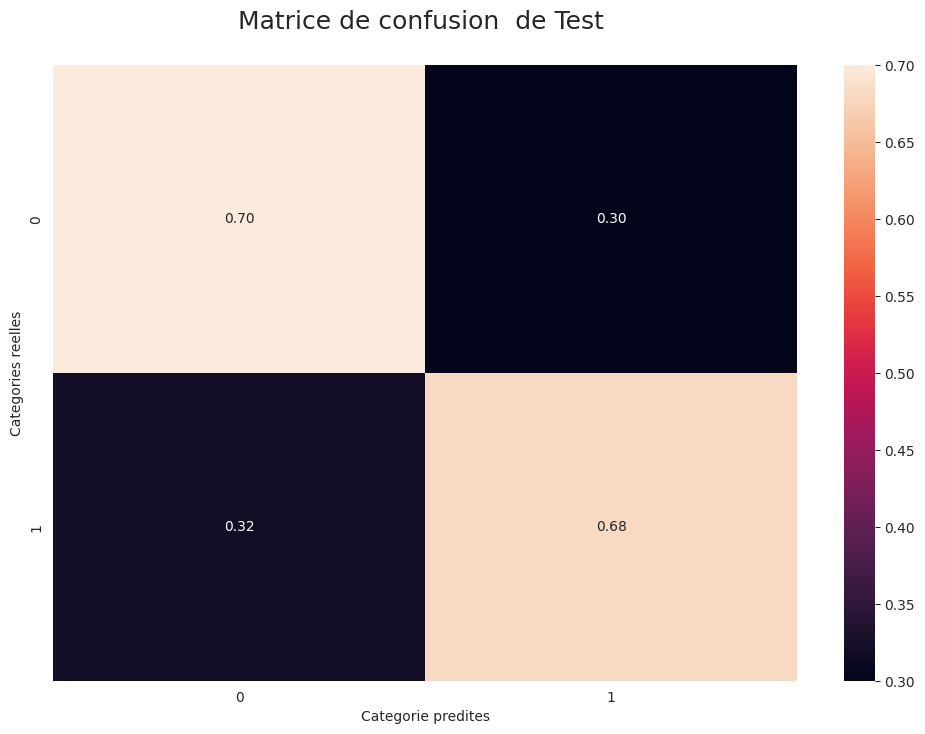

In [13]:
model_and_res = test_model(df,estimator=LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter = 200, penalty = 'l2'), confusion=True)

AVANT MODIF
TRAIN F2 score 0.4712742980561555
TRAIN AUC 0.6662743882355312
TRAIN Recall 0.6688635144455514
TEST F2 score 0.4601743182602693
TEST AUC 0.6581244308054678
TEST Recall 0.6538933169834458

In [14]:
# featimps_lr = u810.logreg_featimps(model_and_res['model']['estimator'],X_train.columns, n_coefs=X_train.shape[1])

In [15]:
# featimps_lr.to_csv('./processed_data/featimps_lr_noext_mbrk_v0.csv')

In [16]:
# test_model(df, estimator=RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=200, n_estimators=500), confusion=True)

In [17]:
# df_train = pd.read_csv('./input_data/application_train.csv')
# df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)

In [18]:
# X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
# y = df['TARGET']
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
# print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
# print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")
#
# imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# scaler = StandardScaler()
# over = SMOTE(random_state=RANDOM_STATE)
# under = RandomUnderSampler(random_state=RANDOM_STATE)
# estimator = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=200, n_estimators=500)
#
# pipeline = Pipeline([
#     ("imputer", imputer),
#     ("scaler", scaler),
#     ("over", over),
#     ("under", under),
#     ("estimator", estimator)
# ])
#
# params = {
#     'over__sampling_strategy' : [0.1, 0.2, 0.3],
#     'under__sampling_strategy' : [0.2, 0.5, 0.7]
# }
#
# cv = StratifiedKFold(n_splits=5)
#
# model = GridSearchCV(
#     estimator=pipeline,
#     param_grid=params,
#     cv=cv,
#     scoring=custom_score,
#     return_train_score=True,
#     verbose=2,
#     n_jobs=-1
# )
#
# model.fit(X_train, y_train)

In [19]:
# print("grid best params : ", model.best_params_)
# grid_res, grl = u810.grid_resultification(model)

class_weight='balanced', max_depth=10, min_samples_split=200, n_estimators=500
= (0.3687393687393687, 0.6582087481044437, 0.5980993255671367)

for params = params = {
    'over__sampling_strategy' : [0.1, 0.2, 0.3],
    'under__sampling_strategy' : [0.2, 0.5, 0.7]
}
grid best params :  {'over__sampling_strategy': 0.1, 'under__sampling_strategy': 0.7}



In [20]:
# grid_res

PREPARING MODEL
X_train : (175724, 51) // X_test : (43932, 51)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.45191064134652065
TRAIN F2Custom score 0.5517531254082484
TRAIN AUC 0.7321571050366915
TRAIN Recall 0.7444248601425396
TEST F2 score 0.40507882212968466
TEST F2Custom score 0.4919957551536499
TEST AUC 0.6905379950211638
TEST Recall 0.6679950950337217


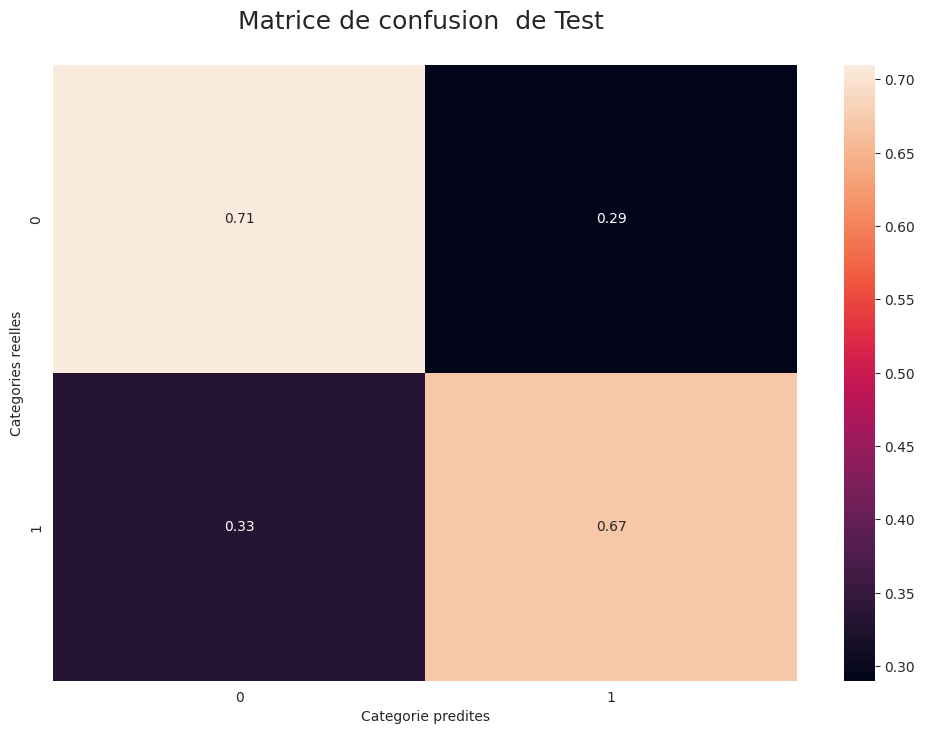

In [21]:
model_and_res = test_model(df, estimator=RandomForestClassifier(class_weight='balanced',max_depth=20 , min_samples_split=200, n_estimators=500), confusion=True, over_sampling=0.1, under_sampling=0.7)

WITHOUT EXT VARIABLES :
TEST F2 score 0.45140756679218214
TEST AUC 0.6612266003666062
TEST Recall 0.6174126302881667

WITH EXT VARIABLES :
TEST F2 score 0.4861174122130479
TEST AUC 0.687540193180535
TEST Recall 0.6569589209074188


AVANT MOD :
TEST F2 score 0.4531505499182402
TEST AUC 0.6622741821274764
TEST Recall 0.6201716738197425

TEST F2 score 0.39771478795869036
TEST F2Custom score 0.48584082673466644
TEST AUC 0.6843384046829342
TEST Recall 0.6658491722869405

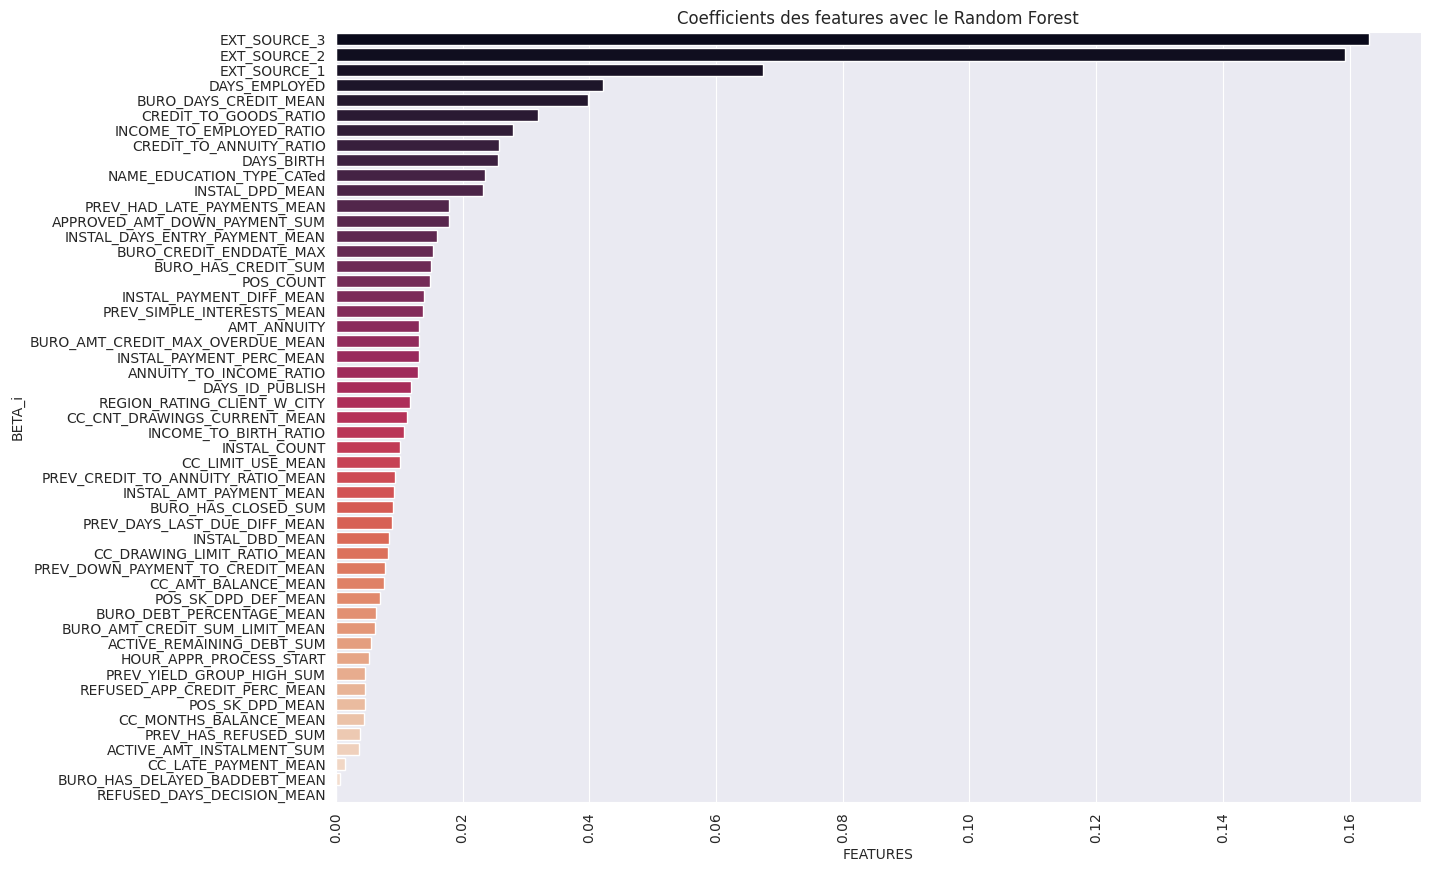

In [22]:
featimps_rf = u810.feature_importance_rf(xtrain=X_train,modelrf=model_and_res['model']['estimator'], size=X_train.shape[1])

In [23]:
featimps_rf.sort_values(by='poids', ascending=True).iloc[:20, :]

,feature,poids
34,REFUSED_DAYS_DECISION_MEAN,0.000000
22,BURO_HAS_DELAYED_BADDEBT_MEAN,0.000633
49,CC_LATE_PAYMENT_MEAN,0.001404
31,ACTIVE_AMT_INSTALMENT_SUM,0.003695
28,PREV_HAS_REFUSED_SUM,0.003853
45,CC_MONTHS_BALANCE_MEAN,0.004512
35,POS_SK_DPD_MEAN,0.004612
32,REFUSED_APP_CREDIT_PERC_MEAN,0.004631
27,PREV_YIELD_GROUP_HIGH_SUM,0.004632
5,HOUR_APPR_PROCESS_START,0.005212


In [24]:
featimps_rf.to_csv('./processed_data/featimps_rf_noext_mbrk_3.csv')

In [25]:
# Xl = X[featimps_rf['feature'].values.tolist()]
# X_train, X_test, y_train, y_test = train_test_split(Xl, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
# print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
# print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

In [26]:
# imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# scaler = StandardScaler()
# over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
# under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
# estimator = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=200, n_estimators=500)
#
# be = Pipeline([
#     ("imputer", imputer),
#     ("scaler", scaler),
#     ("over", over),
#     ("under", under),
#     ("estimator", estimator)
# ])
#
# be.fit(X_train, y_train)
#
# print("TESTING MODEL")
# y_pred = be.predict(X_test)
# y_train_pred = be.predict(X_train)
#
# fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# train_auc_score = auc(fpr, tpr)
# train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
# train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
# print("TRAIN F2 score", train_F2_score)
# print("TRAIN AUC", train_auc_score)
# print("TRAIN Recall", train_rappel)
#
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# test_auc_score = auc(fpr, tpr)
# test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
# test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
# print("TEST F2 score", test_F2_score)
# print("TEST AUC", test_auc_score)
# print("TEST Recall", test_rappel)